![image](logo-Escape_cropped.png)

# An Introduction To Gravitational Wave Data Analysis

We provide an introduction to some gravitational wave (GW) data analysis. The aim of this notebook lecture is to provide the readers with basic knowledge of python packages dseigned to provide access to open data, and carry out basic analyses on such data. The packages we chose can be installed in your local machine via conda or pip and some are also available in dockers. We will deal with the following three libraries:

**gwosc** : this package provides an interface to querying the open data releases hosted at the [Gravitational Wave Open Science Center (GWOSC)](https://gw-openscience.org) from the GEO, LIGO, and Virgo gravitational-wave observatories. The data can be downloaded as .gwf or .h5 files.

**gwpy** : this package (see documentation and examples [GWpy](https://gwpy.github.io/docs/stable/index.html)) provides tools for studying data from ground-based gravitational-wave detectors in the time and frequency domain. It's pretty straightforward for beginners. We will use this library to explore GW signals in time and frequency domain.

**pycbc** : PyCBC is a software package used to explore astrophysical sources of gravitational waves. It contains algorithms that can detect coalescing compact binaries and measure the astrophysical parameters of detected sources. PyCBC was used in the first direct detection of gravitational waves (GW150914) by LIGO and is used in the ongoing analysis of LIGO and Virgo data. We will use this library to generate waveforms, explore detectors, and compute matched filter timeseries. You can find pyCBC tutorials both in the [documentation](http://pycbc.org/pycbc/latest/html/) and [pyCBC github](https://github.com/gwastro/PyCBC-Tutorials) pages.

First, we just import some stuff which may be useful for plotting and other tasks. 

In [1]:
import sys
import os
import numpy as np
from numpy.fft import *
pretty=True #False
if pretty==True:
    %matplotlib notebook 
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.colors import LogNorm
from scipy.signal import *
import scipy.io
import scipy
from astropy.utils import iers
iers.conf.auto_download = False
import warnings

We import the three gravitational wave packages used in this tutorial. NOTE: others exist, see at the [GWOSC Software Utilities](https://www.gw-openscience.org/software/)

In [2]:
import gwosc
import gwpy
import pycbc

In [3]:
print(gwosc.__version__)
print(gwpy.__version__)
print(pycbc.__version__)
print(sys.executable)

0.5.6
2.0.4
1.18.1
/home/cecilio/.conda/envs/eschool2021/bin/python


## Finding datasets with the GWOSC library

In [4]:
from gwosc.datasets import find_datasets, event_gps, run_segment
from gwosc.locate import get_event_urls
from gwosc import datasets

The GWOSC library provides a flexible way to find released public datasets from LIGO/Virgo science runs. The `gwosc.datasets.find_datasets` function allows to browse datasets based on user inputs such as detector, detector run and GW events. Let us check the function:

In [5]:
#find_datasets??

We can for instance request the list of events for a specific detector (*V1*,*L1*,*H1*,*G1*):

In [6]:
V1_events = find_datasets(detector="V1")           # try the other 2 Advanced detectors
print(V1_events)

['190924_232654-v1', '191223_014159-v1', '191225_215715-v1', '200114_020818-v1', 'GW170729-v1', 'GW170809-v1', 'GW170814-v1', 'GW170814-v2', 'GW170814-v3', 'GW170817-v1', 'GW170817-v2', 'GW170817-v3', 'GW170818-v1', 'GW190408_181802-v1', 'GW190412-v1', 'GW190412-v2', 'GW190412-v3', 'GW190413_052954-v1', 'GW190413_134308-v1', 'GW190425-v1', 'GW190425-v2', 'GW190426_152155-v1', 'GW190503_185404-v1', 'GW190512_180714-v1', 'GW190513_205428-v1', 'GW190517_055101-v1', 'GW190519_153544-v1', 'GW190521-v1', 'GW190521-v2', 'GW190521-v3', 'GW190602_175927-v1', 'GW190620_030421-v1', 'GW190630_185205-v1', 'GW190701_203306-v1', 'GW190706_222641-v1', 'GW190708_232457-v1', 'GW190720_000836-v1', 'GW190727_060333-v1', 'GW190728_064510-v1', 'GW190803_022701-v1', 'GW190814-v1', 'GW190814-v2', 'GW190828_063405-v1', 'GW190828_065509-v1', 'GW190910_112807-v1', 'GW190915_235702-v1', 'GW190924_021846-v1', 'GW190929_012149-v1', 'GW200105-v1', 'GW200115-v1', 'GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'Init

It is also possible to list available catalogs (you can then choose your event from the catalog paper, for instance [GWTC-2](https://arxiv.org/pdf/2010.14527.pdf)):

In [7]:
print("List of available catalogs: \n \n", find_datasets(type="catalog"))    # try other type: "event"

List of available catalogs: 
 
 ['GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'Initial_LIGO_Virgo', 'O1_O2-Preliminary', 'O3_Discovery_Papers', 'O3_IMBH_marginal']


and then print events from a selected catalog:

In [8]:
gwtc = datasets.find_datasets(type='event', catalog='O3_Discovery_Papers')
#gwtc = datasets.find_datasets(type='event', catalog='GWTC-2')
#gwtc = datasets.find_datasets(type='catalog', catalog='O3_Discovery_Papers')
print('O3 events:', gwtc)

O3 events: ['GW190412-v1', 'GW190412-v2', 'GW190425-v1', 'GW190521-v1', 'GW190521-v2', 'GW190814-v1', 'GW200105-v1', 'GW200115-v1']


The *run* type lists the strain data sets from LIGO/Virgo observing runs. These refer to large datasets and include sampling frequencies (which can be at 4 or 16 KHz).



In [9]:
runs = find_datasets(type='run')
print('Full datasets from runs:', runs)

Full datasets from runs: ['BKGW170608_16KHZ_R1', 'O1', 'O1_16KHZ', 'O2_16KHZ_R1', 'O2_4KHZ_R1', 'O3a_16KHZ_R1', 'O3a_4KHZ_R1', 'S5', 'S6', 'oldhistory']


We can print the GPS starting and end time of the above datasets, with the `gwosc.datasets.run_segment` function:

In [10]:
#run_segment??

In [11]:
print(run_segment('O2_4KHZ_R1'))

(1164556817, 1187733618)


Let us now take an event from the above list (*e.g.* **GW190521-v2** ). The `gwosc.datasets.event_gps` function returns the GPS time since January 6, 1980.

In [12]:
gps_ev = event_gps('GW190521-v2')
print(gps_ev)

1242442967.4


Starting from an event identifier, we can recover the url pointing to associated HDF5 data files with the `gwosc.locate.get_event_urls` function:

In [13]:
urls = get_event_urls('GW190521-v2')
print(urls)

['https://www.gw-openscience.org/eventapi/json/O3_Discovery_Papers/GW190521/v2/H-H1_GWOSC_4KHZ_R2-1242442952-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/O3_Discovery_Papers/GW190521/v2/H-H1_GWOSC_4KHZ_R2-1242440920-4096.hdf5', 'https://www.gw-openscience.org/eventapi/json/O3_Discovery_Papers/GW190521/v2/L-L1_GWOSC_4KHZ_R2-1242442952-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/O3_Discovery_Papers/GW190521/v2/L-L1_GWOSC_4KHZ_R2-1242440920-4096.hdf5', 'https://www.gw-openscience.org/eventapi/json/O3_Discovery_Papers/GW190521/v2/V-V1_GWOSC_4KHZ_R2-1242442952-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/O3_Discovery_Papers/GW190521/v2/V-V1_GWOSC_4KHZ_R2-1242440920-4096.hdf5']


## GWpy: access and analyze datasets

In [14]:
from gwpy.timeseries import TimeSeries

*GWpy* is a python package which providese straightforward tools to analyze data from ground-based GW interferometers. The method to fetch data from a particular event is `fetch_open_data` from the `gwpy.timeseries.TimeSeries` class. Let us investigate the method:



In [15]:
#TimeSeries.fetch_open_data??

We can fetch the data from the event selected in the previous section (**GW190521**) and from a particular interferometer (*e.g.* Ligo Livingston *L1*). 

In [16]:
seg_hlen = 8
l1_data = TimeSeries.fetch_open_data('L1', gps_ev-seg_hlen, gps_ev+seg_hlen, verbose=True)  # cache=True stores file on your computer.
print(l1_data)

Fetched 1 URLs from www.gw-openscience.org for [1242442959 .. 1242442976))
Reading data... [Done]
TimeSeries([-1.07863873e-19, -1.06164848e-19, -1.03325326e-19,
            ...,  1.16783620e-19,  1.18440762e-19,
             1.20362983e-19]
           unit: dimensionless,
           t0: 1242442959.3999023 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


### Time and frequency domain data

GWpy is used to deal with time series and frequency series. The `gwpy.timeseries.timeseries.TimeSeries.plot` method allows to directly plot objects from the Timeseries class, with UTC time in the label.

In [17]:
#type(gwpy.frequencyseries.frequencyseries.FrequencySeries) 

In [18]:
#gwpy.timeseries.timeseries.TimeSeries.plot??

<IPython.core.display.Javascript object>


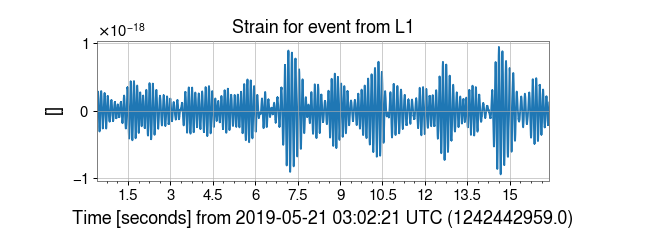

In [19]:
plot = l1_data.plot(figsize=(8, 3), title='Strain for event from L1');

We can recover the frequency content of the above time series by using the `gwpy.timeseries.Timeseries.fft` function (based on `numpy.fft.rfft`) which yields a `FrequencySeries` instance, appropriately normalized.


In [20]:
#TimeSeries.fft??

<IPython.core.display.Javascript object>


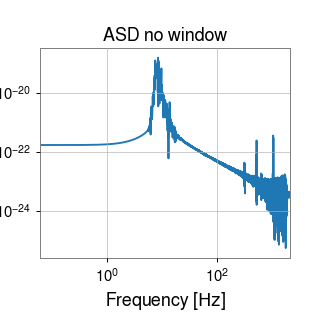

In [21]:
fft = TimeSeries.fft(l1_data)
plot = fft.abs().plot(xscale="log", yscale="log",figsize=(4,4), title='ASD no window')

<IPython.core.display.Javascript object>


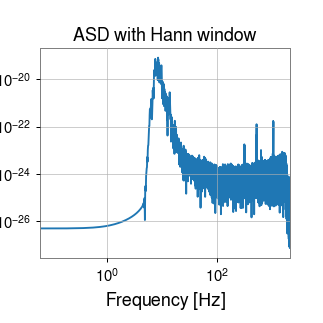

In [22]:
from scipy.signal import get_window
window = get_window('hann', l1_data.size)   # Grab window using scipy library
lwin = l1_data * window

#plt.figure(figsize=(3,2))         # matplotlib.pyplot plot!!
#plt.plot(window, 'r'), plt.title('Hann window')
#TimeSeries(window).plot()

fftamp = lwin.fft().abs()
plot_new = fftamp.plot(xscale="log", yscale="log", figsize=(4,4), title='ASD with Hann window')

Instead of applying a single FFT, it is good practice to recover the spectral properties of the GW strain applying an averaging method. This can be achieved with the `gwpy.timeseries.TimeSeries.asd`, which returns an averaged ASD computed with the segment, into a FrequencySeries.

In [23]:
#gwpy.timeseries.TimeSeries.asd??

<IPython.core.display.Javascript object>


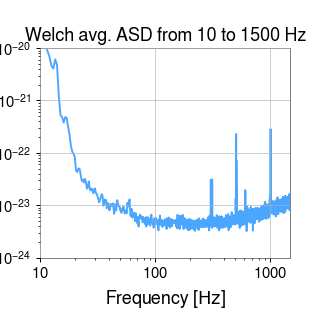

In [24]:
asd_l1 = l1_data.asd(fftlength=2, window='hann', method="welch")
plot = asd_l1.plot(title='Welch avg. ASD from 10 to 1500 Hz', figsize=(4,4), color='gwpy:ligo-livingston')
ax = plot.gca()           # get current axis to modify plot axes' intervals
ax.set_xlim(10, 1500)
ax.set_ylim(1e-24, 1e-20);

This is what a typical GW detector ASD curve looks like. It is the sum of contributions by a wide variety of noise sources (seismic and newtonian, thermal, quantum *etc etc*). We can observe in particular some spectral lines and peaks (see for instance, the description for O2 lines https://www.gw-openscience.org/o2speclines/)

### EXERCISE 1: plot averaged ASD for GW190521 and all three Advanced Detectors

Plot the same interval around **GW190521** for all detectors, to appreciate the different sensitivities during the desired time interval. 

### Time-Frequency representation

It is quite difficult to find low SNR events just by looking at ASD and timeseries. Therefore, a time-frequency representation is preferred, which tracks the evolution of the ASD or PSD in time. We can compute a time frequency representation using the TimeSeries methods `spectrogram` and/or `spectrogram2`.

In [25]:
##gwpy.timeseries.TimeSeries.spectrogram??

In [26]:
##gwpy.timeseries.TimeSeries.spectrogram2??

<IPython.core.display.Javascript object>


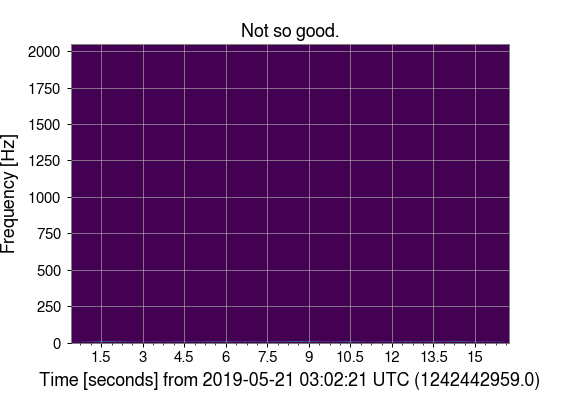

In [27]:
specgram = l1_data.spectrogram2(fftlength=1, overlap=0.8, window='hann') ** (1/2.)
plot = specgram.plot(title='Not so good.', figsize=(7,5))

adjust=False
if adjust==True:
    ax = plot.gca()
    ax.set_yscale('log')
    ax.set_ylim(10, 1500)
    ax.colorbar(
        clim=(1e-24, 1e-20),
        norm="log",
        label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
    )
    ax.set_title('Better!')
    #plot  # refresh

A better way is to use multi-resolution methods, such as the wavelet transform or the [*Q*-transform](https://arxiv.org/pdf/gr-qc/0412119.pdf), which involves logarithmic tiling in the time–frequency plane. The quantity Q is a measure of the burst’s aspect ratio in the
time-frequency plane $f_c/\sigma_f$.


In [28]:
#gwpy.timeseries.TimeSeries.q_transform??

<IPython.core.display.Javascript object>


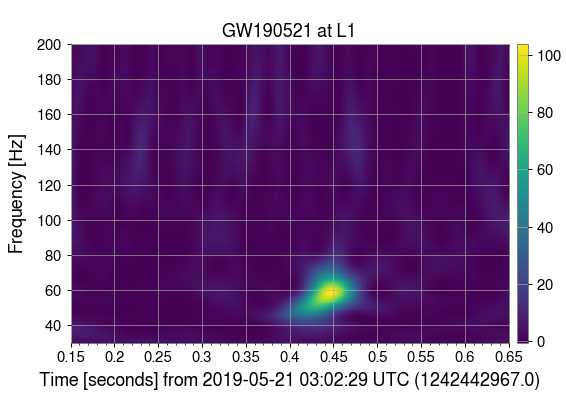

In [29]:
l1_q = l1_data.q_transform(frange=(30, 200), outseg=(gps_ev-0.25,gps_ev+0.25))   # outseg to zoom around merger
plot = l1_q.plot(title='GW190521 at L1', figsize=(7,5))
plot.colorbar(label="Normalised energy");


Uncomment if you want to see the same segment in the Virgo interferometer!

In [30]:
#v1_q = v1_data.q_transform(frange=(30, 200), outseg=(gps_ev-0.25,gps_ev+0.25))
#plot = v1_q.plot(title='GW190521 at V1', figsize=(7,5))
#plot.colorbar(label="Normalised energy");

### EXERCISE 2: plot the Q-transform for GW170817

Now that you know how to plot a time-frequency representation, let us focus on the long GW binary neutron star (BNS) signal **GW170817**, corresponding to the first joint GW/EM multi-messenger observation. Try to complete the following steps or answer the question:
    1. Fetch the data for the three detectors.
    2. Plot the Q-Transform (try choosing the appropriate values of the frange and qrange, and of outseg).
    3. In which detectors is the signal visible?
    4. Any ideas on what's happening to Ligo Livingston (L1) data?


## PyCBC library for compact binary collapse signals

In [31]:
import pycbc.filter
from pycbc import types
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

[PyCBC](https://pycbc.org/pycbc/latest/html/index.html) is a python package used to analyze gravitational wave signals. It includes algorithms for detection and parameter estimation of coalescing compact binary signals and is one of the official LIGO and Virgo collaboration pipelines running in real time. It deploys the matched filtering method used in multiple detections throughout O1, O2 and O3 science runs.

### Generating a waveform from source parameters

Before showing an example of application to real data, we briefly present some useful functions. First of all, we show how to generate a *chirp* signal from a coalescing binary with given parameters. We use the function `pycbc.waveform.get_td_waveform` which outputs the "plus" and "cross" polarizations ($h_+$,$h_\times$) of the gravitational-wave signal observed from the line of sight at a given source inclination $i$ ($i=0$ by default). Let us plot a binary with component masses $12 M\odot$ and $15 M_\odot$, with a $4$kHz sampling.

In [32]:
#get_td_waveform??

In [33]:
f_samp = 4096
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",       # others, such as "IMRPhenomD"
                         mass1=12,                         # in solar masses
                         mass2=15,
                         delta_t=1.0/f_samp,
                         f_lower=30,
                         distance=100,                     # in Mpc
                         inclination=0)                    # in radians  

In [34]:
type(hp)

pycbc.types.timeseries.TimeSeries

Let us plot the signal with *matplotlib*:

<IPython.core.display.Javascript object>


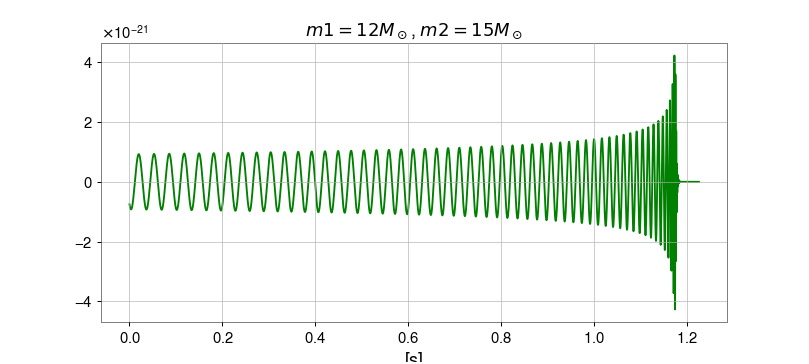

In [35]:
plt.figure(figsize=(10,4.5))
plt.plot(np.arange(0,len(hp))/f_samp, hp+hc, 'g')
plt.xlabel('[s]')
plt.title(r'$m1 = 12M_\odot$, $m2 = 15M_\odot$');

We can also plot the individual polarizations and use the times contained in pyCBC's TimeSeries ($t=0$ at merger!):

<IPython.core.display.Javascript object>


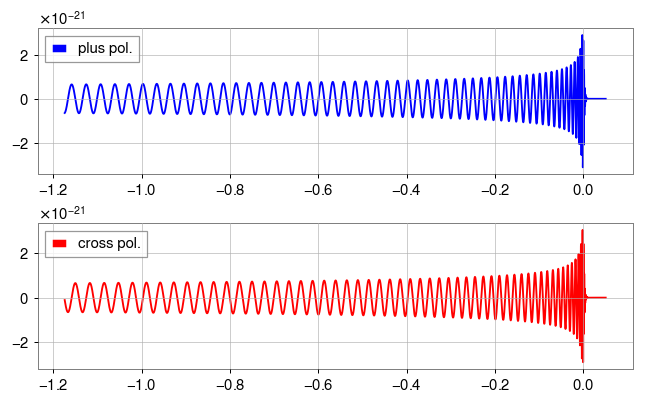

In [36]:
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(hp.sample_times, hp, 'b', label='plus pol.')
plt.legend()
plt.subplot(2,1,2)
plt.plot(hc.sample_times, hc, 'r', label='cross pol.')
plt.legend()
plt.tight_layout(pad=1)

### Detectors

In [37]:
from pycbc.detector import Detector, get_available_detectors

The `pycbc.detector` module allows us to carry out a number of operations involving GW detectors and their positions. We can list the available detectors, along with their abbreviation:

In [38]:
print(get_available_detectors())

[('T1', 'TAMA_300'), ('V0', 'VIRGO_CITF'), ('V1', 'VIRGO'), ('G1', 'GEO_600'), ('H2', 'LHO_2k'), ('H1', 'LHO_4k'), ('L1', 'LLO_4k'), ('I1', 'LIO_4k'), ('C1', 'CIT_40'), ('E1', 'ET1_T1400308'), ('E2', 'ET2_T1400308'), ('E3', 'ET3_T1400308'), ('E0', 'ET0_T1400308'), ('K1', 'KAGRA'), ('U1', 'ACIGA'), ('A1', 'ALLEGRO_320'), ('O1', 'AURIGA'), ('X1', 'EXPLORER'), ('N1', 'Nautilus'), ('B1', 'NIOBE')]


As an example, we can print out the longitude and latitude of each detector:

In [39]:
for abv, long_name in get_available_detectors():
    d = Detector(abv)
    print("{} Latitude {} Longitude {}".format(abv, d.latitude, d.longitude))    # Latitude and longitude in radians

T1 Latitude 0.6226733601781139 Longitude 2.435363594690946
V0 Latitude 0.7615118398044829 Longitude 0.1833380521285067
V1 Latitude 0.7615118398044829 Longitude 0.1833380521285067
G1 Latitude 0.9118498274833728 Longitude 0.17116780434996115
H2 Latitude 0.810795263791696 Longitude -2.0840567691659397
H1 Latitude 0.810795263791696 Longitude -2.0840567691659397
L1 Latitude 0.5334231350225018 Longitude -1.5843093707829259
I1 Latitude 0.24841853018214574 Longitude 1.3340133249409996
C1 Latitude 0.5963790053711457 Longitude -2.0617574453805614
E1 Latitude 0.7615118398044829 Longitude 0.1833380521285067
E2 Latitude 0.7629930799052169 Longitude 0.18405858870223898
E3 Latitude 0.7627046325725655 Longitude 0.18192996730110464
E0 Latitude 0.7627046325725655 Longitude 0.18192996730110464
K1 Latitude 0.6355068496865413 Longitude 2.396441015339088
U1 Latitude 1.5707963267948966 Longitude 0.0
A1 Latitude 0.5307987920242562 Longitude -1.591370684957212
O1 Latitude 0.7915649933828905 Longitude 0.2085377

### EXERCISE 3: print light travel distances between L1, H1, V1 

Discover the `Detector.light_travel_travel_time_to_detector` function to carry out the task.

Now we want to take the waveform we previously generated, with its two polarizations $h_+$ and $h_\times$, and project it into a detector. Each detector has its own antenna pattern, which means its sensitivity to a GW signal depends on the sky position of the GW source. We can use the `Detector.antenna_pattern` function to recover the weight factors for the two polarizations (NOTE: short signals!).

In [40]:
#Detector.antenna_pattern??

The antenna pattern factors are fp=-0.09374146347095322, fc=-0.3393363960393486


<IPython.core.display.Javascript object>


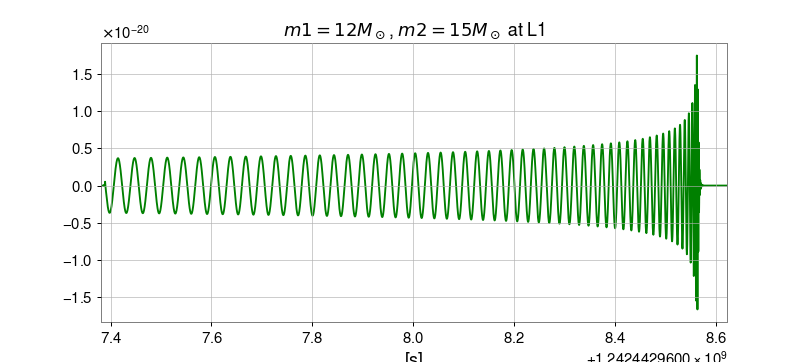

In [41]:
### Right ascension, declination, polarization angle and inclination angle (radians), GPS time
ra = 1.7
dec = 1.7
pol = 0.2
inc = np.pi/4
time = 1242442967.4

### Recall how we produced the above waveform
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", mass1=12, mass2=15,
                         f_lower=30, delta_t=1.0/f_samp, inclination=0,
                         distance=10)

det = Detector("L1")                                  # Let's chooose the LIGO Livingston detector
fp, fc = d.antenna_pattern(ra, dec, pol, time)        # weight factors for h+ and hx
print("The antenna pattern factors are fp={}, fc={}".format(fp, fc))

### Apply the antenna pattern factors to the two polarizations, then sum and plot
ht = fp * hp + fc * hc

### ALTERNATIVE: the project_wave_function.
hp.start_time = hc.start_time = time
ht = det.project_wave(hp, hc, ra, dec, pol)
plt.figure(figsize=(10,4.5))
plt.plot(ht.sample_times, ht, 'g')
plt.xlabel('[s]')
plt.xlim(min(ht.sample_times), max(ht.sample_times))
plt.title(r'$m1 = 12M_\odot$, $m2 = 15M_\odot$ at ' + det.name);







### EXERCISE 4 (extra): project and plot signal on all detectors.

### Computing the Matched Filter SNR of GW170814

In [42]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pycbc.catalog

Let's see an example of matched filter SNR computation for [GW170814](https://en.wikipedia.org/wiki/GW170814). Matched filter is a procedure for signal detection, based on "matching" a template to the data taking into account the background noise content with an appropriate weighting.

In [43]:
gwtc2_events = pycbc.catalog.Catalog(source='O3_Discovery_Papers')
print(gwtc2_events.names)


dict_keys(['GW190412-v1', 'GW190412-v2', 'GW190425-v1', 'GW190521-v1', 'GW190521-v2', 'GW190814-v1', 'GW200105-v1', 'GW200115-v1'])


<IPython.core.display.Javascript object>


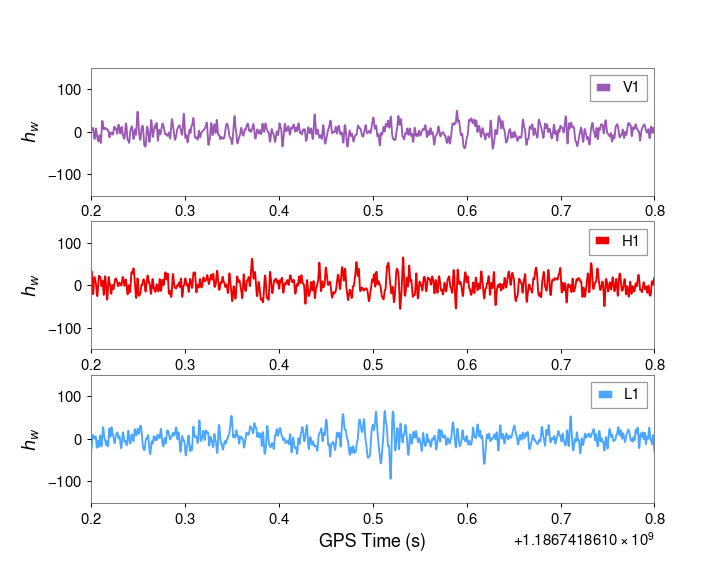

In [44]:
plt.figure(figsize=(9,7))
i_c=1
for ifo in ['V1','H1', 'L1']:
    # Read data and remove low frequency content
    h1 = Merger('GW170814',source='gwtc-1').strain(ifo)
    h1 = highpass_fir(h1, 15, 8)
    merger_time = Merger('GW170814',source='gwtc-1').time

    # Calculate the noise spectrum
    psd = interpolate(welch(h1), 1.0 / h1.duration)

    # whiten
    white_strain = (h1.to_frequencyseries() / psd ** 0.5).to_timeseries()

    # remove some of the high and low
    smooth = highpass_fir(white_strain, 20, 8)
    smooth = lowpass_fir(white_strain, 300, 8)

    # time shift and flip L1
    if ifo == 'H1':
        itf_color='gwpy:ligo-hanford'
    elif ifo == 'L1':
        itf_color='gwpy:ligo-livingston'
    elif ifo == 'V1':
        itf_color='gwpy:virgo'
    
    plt.subplot(3,1,i_c)
    plt.plot(smooth.sample_times, smooth, label=ifo, color=itf_color)
    plt.legend()
    plt.xlim(merger_time-0.3, merger_time+0.3)
    plt.ylim(-150, 150)
    plt.ylabel(r'$h_w$')
    plt.grid()
    plt.xlabel('GPS Time (s)')
    i_c+=1



We are now ready to compute the SNR time series using a template from our template bank, but first, we import the `pycbc.filter.matched_filter` function and `pycbc.waveform.get_fd_waveform`, which differs from the one previously defined. The matched filter procedure is carried out in the frequency domain, see [Allen et al. 2012](https://journals.aps.org/prd/pdf/10.1103/PhysRevD.85.122006).

In [45]:
from pycbc.filter import matched_filter
from pycbc.waveform import get_fd_waveform

We then choose a template and produce the SNR time series for LIGO Livingston. In our case, we cheat on the component masses. :)

<IPython.core.display.Javascript object>


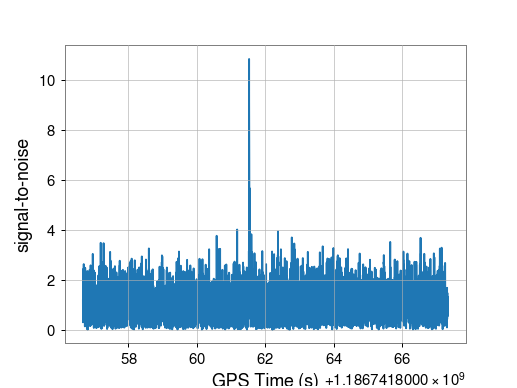

In [46]:
# Generate a template to filter with
hp, hc = get_fd_waveform(approximant="IMRPhenomD", mass1=30.5, mass2=25.3,
                         f_lower=20, delta_f=1.0/h1.duration)
hp.resize(len(h1) // 2 + 1)

# Calculate the complex (two-phase SNR)
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=20.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) // 3: len(snr) * 2 // 3]


plt.figure()
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('signal-to-noise')
plt.xlabel('GPS Time (s)');


### EXERCISE 1: solution

In [47]:
gps_ev

1242442967.4

In [48]:
# Hanford H1
h1_data = TimeSeries.fetch_open_data('H1', gps_ev-seg_hlen, gps_ev+seg_hlen)
asd_h1 = h1_data.asd(fftlength=4, window='hann', method="welch")

# Virgo V1
v1_data = TimeSeries.fetch_open_data('V1', gps_ev-seg_hlen, gps_ev+seg_hlen)
asd_v1 = v1_data.asd(fftlength=4, window='hann', method="welch")

In [49]:
plot_all = asd.plot(title='Welch avg. ASD from 10 to 1500 Hz', figsize=(4,4), color='gwpy:ligo-livingston')
ax2 = plot_all.gca()           # get current axis 
ax2.plot(asd_h1, label='H1', color='gwpy:ligo-hanford')
ax2.plot(asd_v1, label='V1', color='gwpy:virgo')
ax2.plot(asd_l1, label='L1', color='gwpy:ligo-livingston')

ax2.set_xlim(10,1500)
ax2.set_ylim(1e-24, 1e-20)
ax2.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax2.legend()
plot;

NameError: name 'asd' is not defined

### EXERCISE 2: solution

Typically, BNS mergers reach up to higher frequencies (the maximum $f_{merger}$ is lower for more massive binaries). We therefore have to chose the frequency range accordingly.

In [ ]:
### 1.
event_list = datasets.find_datasets(type='events', catalog='GWTC-1-confident')
print(event_list)

dt=16
gps_GW = event_gps('GW170817-v3')
h1_GW = TimeSeries.fetch_open_data('H1', gps_GW-dt, gps_GW+dt)
l1_GW = TimeSeries.fetch_open_data('L1', gps_GW-dt, gps_GW+dt)
v1_GW = TimeSeries.fetch_open_data('V1', gps_GW-dt, gps_GW+dt)

### 2.
h1_qGW = h1_GW.q_transform(frange=(30, 500), qrange=(100,110), outseg=(gps_GW-3,gps_GW+3))   # recall outseg to zoom
l1_qGW = l1_GW.q_transform(frange=(30, 500), qrange=(100,110), outseg=(gps_GW-3,gps_GW+3))   
V1_q = v1_GW.q_transform(frange=(30, 500), qrange=(100,110), outseg=(gps_GW-3,gps_GW+3))   

In [ ]:
### 3. The signal is clearly visible at LIGO Hanford
plotGW_h1 = h1_qGW.plot(title='GW190521 at H1', figsize=(7,5))
plotGW_l1 = l1_qGW.plot(title='GW190521 at L1', figsize=(7,5))
plotGW_v1 = V1_q.plot(title='GW190521 at V1', figsize=(7,5))
ax_GW = plot.gca()
ax_GW.set_yscale('log')
ax_GW.colorbar(label="Normalised energy");

### 4. An instrumental glitch is saturating the LIGO Livingston data!

### EXERCISE 3: solution

In [ ]:
itfs=['L1','H1','V1']
ii=0
for itf1 in itfs:
    ii+=1
    for itf2 in itfs[ii:]:
        tt =Detector.light_travel_time_to_detector(Detector(itf1), Detector(itf2))
        print("Light travel time from {} to {} is {} seconds".format(itf1, itf2, tt))
        